```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is a prototype for all required parts of a realistic simulation

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from matplotlib import animation, rc, colors, colorbar
from matplotlib import pyplot as plt

from IPython.display import display
from IPython.display import Video

#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities, NetCDFInitialization

In [3]:
%setup_logging -o lofoten_sim.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger using level DEBUG to lofoten_sim.log
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94735500033456>


In [4]:
#Set this to false before comitting to only get images
create_movie = False
movie_frames = 200 
download_data = True

# Select area and result folder

In [5]:
#case = 1 # Open waters in the Norwegian Sea
#case = 2 # Lofoten
case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'

if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'complete_coast_2019_10_09'

assert(folder.startswith(casename)), 'folder does not start with casename!'

os.makedirs(folder, exist_ok=True)
print(folder)

complete_coast_2019_10_24


# Misc helper functions

In [6]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=0,
                 ax=None, sp=None,
                 rotate=False, downsample=None):
    if (plt.rcParams["text.usetex"]):
        comment = PlotHelper.tex_escape(comment)
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    x_plots = 1
    y_plots = 1
    
    if (downsample is not None):
        eta = eta[::downsample, ::downsample]
        h = h[::downsample, ::downsample]
        hu = hu[::downsample, ::downsample]
        hv = hv[::downsample, ::downsample]
    
    if (add_extra == 1):
        x_plots=3
        y_plots=1
    elif (add_extra == 2):
        x_plots=3
        y_plots=2
        
    if (add_extra == 2):
        V_max = 5 * (uv_max-uv_min) / np.max(h)
        R_min = -V_max/2
        R_max = V_max/2
        
        V = PlotHelper.genVelocity(h, hu, hv)
        R = PlotHelper.genColors(h, hu, hv, plt.cm.seismic, R_min, R_max)
            
    ny, nx = eta.shape
    if (rotate):
        domain_extent = [0, ny*dy/1000, 0, nx*dx/1000]
        eta = np.rot90(eta, 3)
        h = np.rot90(h, 3)
        hu = np.rot90(hu, 3)
        hv = np.rot90(hv, 3)
        
        if (add_extra == 2):
            V = np.rot90(V, 3)
            R = np.rot90(R, 3)
    else:
        domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]
    
    

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        if (add_extra > 0):
            ax[1] = plt.subplot(y_plots, x_plots, 2)
            sp[1] = ax[1].imshow(hu, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[1], shrink=0.9)
            plt.axis('image')
            plt.title("$hu$")

            ax[2] = plt.subplot(y_plots, x_plots, 3)
            sp[2] = ax[2].imshow(hv, interpolation="none", origin='bottom', 
                                 cmap=plt.cm.coolwarm, 
                                 vmin=uv_min, vmax=uv_max, 
                                 extent=domain_extent)
            plt.colorbar(sp[2], shrink=0.9)
            plt.axis('image')
            plt.title("$hv$")

        if (add_extra > 1):
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='bottom', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='bottom', 
                               extent=domain_extent)
            sm = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)
            sm.set_array([])
            fig.colorbar(sm, shrink=0.9)
            #colorbar.Colorbar(ax[4], cmap=plt.cm.seismic, mappable=plt.cm.ScalarMappable(norm=colors.Normalize(vmin=R_min, vmax=R_max), cmap=plt.cm.seismic)colors.Normalize(vmin=R_min, vmax=R_max), orientation='horizontal', shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        if (add_extra > 0):
            fig.sca(ax[1])
            sp[1].set_data(hu)

            fig.sca(ax[2])
            sp[2].set_data(hv)
        
        if (add_extra > 1):
            fig.sca(ax[3])
            sp[3].set_data(V)

            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [7]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [8]:
if (download_data):
    filename = os.path.abspath(os.path.basename(source_url))
    
    if (os.path.isfile(filename)):
        source_url = filename
    
    else:
        import requests
        download_url = source_url.replace("dodsC", "fileServer")

        req = requests.get(download_url, stream = True)
        filesize = int(req.headers.get('content-length'))

        progress = Common.ProgressPrinter()
        pp = display(progress.getPrintString(0),display_id=True)

        print("Downloading data to local file (" + str(filesize // (1024*1024)) + " MB)")
        with open(filename, "wb") as outfile:
            for chunk in req.iter_content(chunk_size = 10*1024*1024):
                if chunk:
                    outfile.write(chunk)
                    pp.update(progress.getPrintString(outfile.tell() / filesize))

        source_url = filename
        
print("Source is : " + source_url)

Source is : /home/andreb/projects/gpu-ocean/gpu_ocean/demos/realisticSimulations/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc


In [9]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875

In [10]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:
    print('using Norwegian Sea area')


using the complete coast case


# Get initial conditions

In [12]:
ic = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1)

# Helpers for plotting and running simulation

In [36]:
def ncSimulation(sim, filename, timesteps, interior_domain_only, num_substeps = 3):
    filename = os.path.join(folder, filename)
    if (os.path.isfile(filename)):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = var['Hm'][:,:]

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        progress = Common.ProgressPrinter(5)
        pp = display(progress.getPrintString(0), display_id=True)
        for i, timestep_size in enumerate(timestep_sizes):
            #Don't simulate if first step (store initial conditions also)
            if (timestep_size > 0):
                substep_size = timestep_size / num_substeps
                for j in range(num_substeps):
                    sim.updateDt()
                    sim.step(substep_size)

            var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
            ncvar['time'][i] = sim.t
            ncvar['num_iterations'][i] = sim.num_iterations

            abort=False
            for varname in ['eta', 'hu', 'hv']:
                ncvar[varname][i,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                if (np.any(np.isnan(var[varname]))):
                    print("Variable " + varname + " contains NaN values!")
                    abort=True

            if (abort):
                print("Aborting at t=" + str(sim.t))
                ncfile.sync()
                break

            pp.update(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

In [37]:
def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, save_movie=True, **kwargs):
    title = filename.replace('_', ' ').replace('.nc', '')
    filename = os.path.join(folder, filename)

    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        ncfile = Dataset(filename)
        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][:]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][:,:,:]
        hu = ncfile.variables['hu'][:,:,:]
        hv = ncfile.variables['hv'][:,:,:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0),display_id=True)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], title,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], title,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, filename, 
                     **kwargs, ax=ax, sp=sp)

        pp.update(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    if (save_movie):
        anim.save(filename + '.mp4')
        plt.close(fig)
        return Video(filename + '.mp4')
    else:
        plt.close(fig)
        return anim

# Plot reference solution

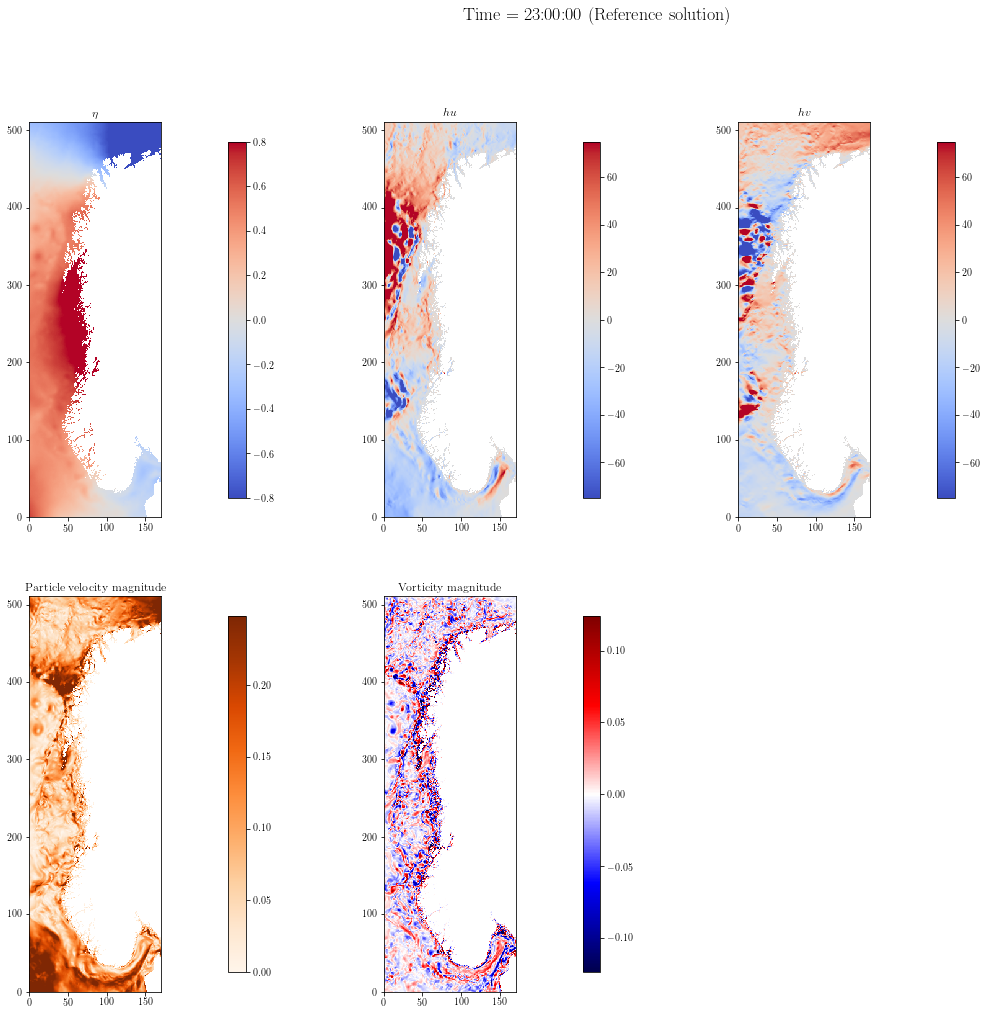

In [38]:
def refAnimation(t, movie_frames=None, create_movie=True, fig=None, save_movie=True, **kwargs):    
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))
    
    tsteps = timesteps
    if (not create_movie):
        tsteps = [tsteps[0]] + [tsteps[-1]]
        
    if movie_frames is None:
        movie_frames = len(tsteps)
        
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][tsteps, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][tsteps, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][tsteps, y0:y1, x0:x1]
        
        for timestep in range(len(tsteps)):
            hu[timestep] = hu[timestep] * (H_m + eta[timestep])
            hv[timestep] = hv[timestep] * (H_m + eta[timestep])
    except Exception as e:
        raise e
    finally:
        ncfile.close()

    
    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], "Reference solution",
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy,
                              t[-1], "Reference solution",
                              **kwargs)
        return
    
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0),display_id=True)
    
    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 
        
        k = np.searchsorted(time, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])
        
        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, "Reference solution",
                     **kwargs, ax=ax, sp=sp)
        
        pp.update(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    
    if (save_movie):
        anim.save('reference.mp4')
        plt.close(fig)
        print("Saving to reference.mp4")
        return Video('reference.mp4')
    else:
        plt.close(fig)
        return anim

refAnimation(time, 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True, 
             downsample=4)

# Run original resolution simulation

In [39]:
importlib.reload(CDKLM16)

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    "coriolis_beta": beta,
    "r": 3.0e-3, 
    "rk_order": 2
}

data_args = getInitialConditions(source_url, x0, x1, y0, y1)
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

ncSimulation(sim=sim, 
             filename=casename+"original.nc",
             timesteps=time,
             interior_domain_only=False)

File complete_coast_2019_10_17/complete_coast_original.nc already exists, skipping simulation.


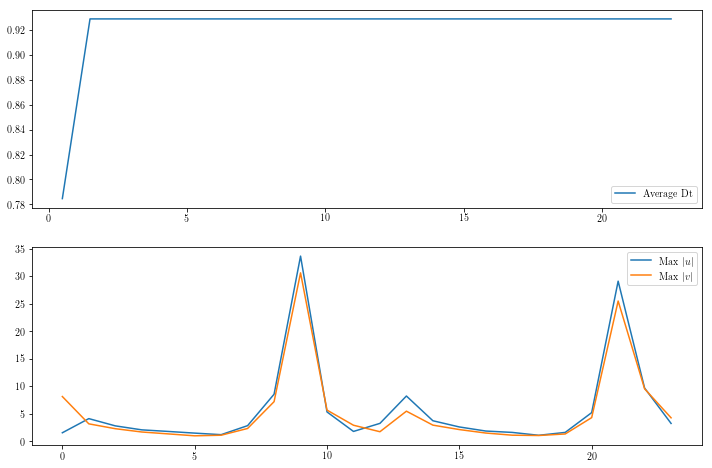

In [40]:
def plotStatistics(filename): 
    filename = os.path.join(folder, filename)
    try:
        ncfile = Dataset(filename)
        t = ncfile.variables['time'][:]
        num_iterations = ncfile.variables['num_iterations'][:]

        num_timesteps = len(t)
        max_abs_u = np.zeros(num_timesteps)
        max_abs_v = np.zeros(num_timesteps)
        
        H_m = ncfile.variables['Hm'][:,:]
        
        for i in range(num_timesteps):
            h = H_m + ncfile.variables['eta'][i,:,:]
            
            u = ncfile.variables['hu'][i,:,:] / h
            v = ncfile.variables['hv'][i,:,:] / h
            
            max_abs_u[i] = np.max(np.abs(u))
            max_abs_v[i] = np.max(np.abs(v))
            
        
    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

    plt.title("Statistics")
    plt.subplot(2,1,1)
    plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), label="Average Dt")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    plt.legend()

plt.figure(figsize=(12,8))
plotStatistics(casename+"original.nc")

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

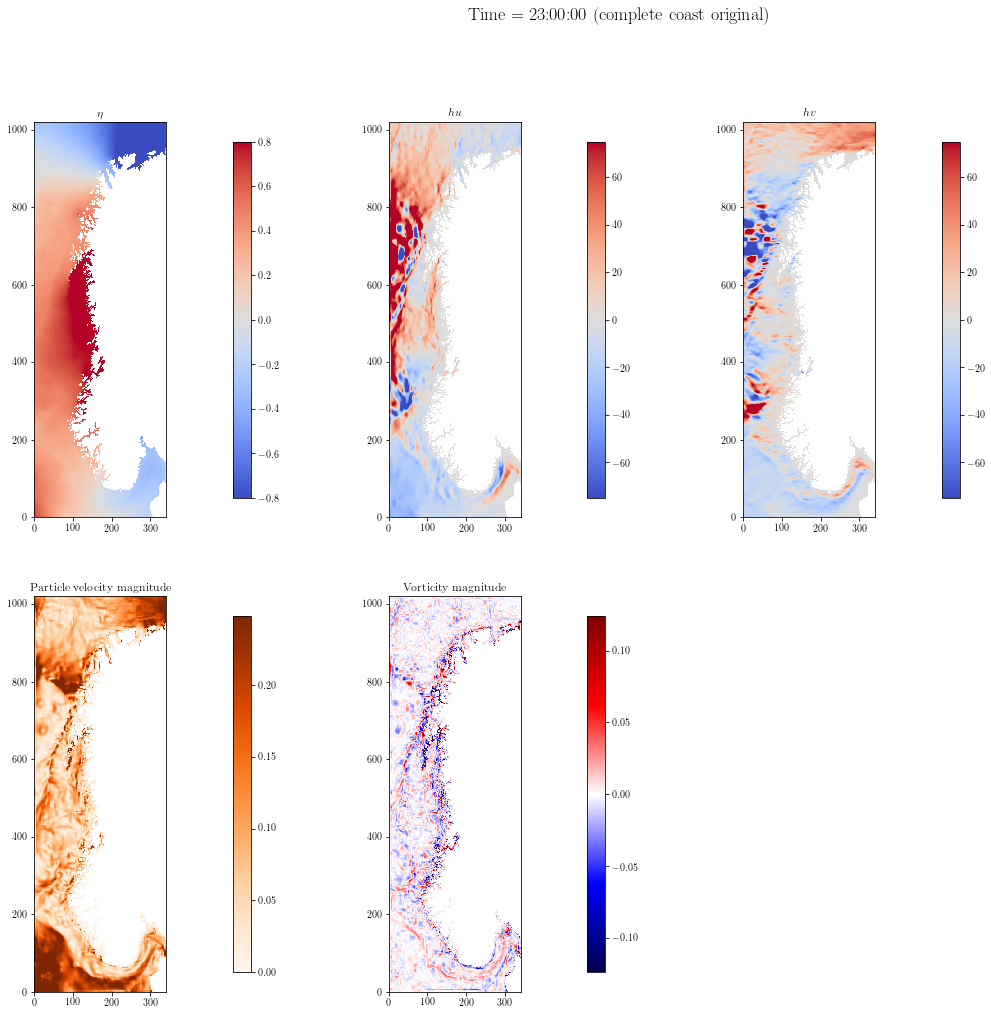

In [41]:
ncAnimation(casename+"original.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True, 
             downsample=2)

# Simulate low-resolution

In [42]:
importlib.reload(OceanographicUtilities)

#Set scaling factor
scale = 0.5

nx_new = int((x1 - x0)*scale) - sponge_cells[1] - sponge_cells[3]
ny_new = int((y1 - y0)*scale) - sponge_cells[0] - sponge_cells[2]

# Set initial conditions
data_args = {"nx": nx_new, "ny": ny_new,
             "dx": dx/scale, "dy": dy/scale,
             "H": OceanographicUtilities.rescaleIntersections(H_i, (H_i.shape[1]-1)*scale+1, (H_i.shape[0]-1)*scale+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind_stress": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename=casename+"lowres.nc",
             timesteps=time,
             interior_domain_only=False)

File complete_coast_2019_10_17/complete_coast_lowres.nc already exists, skipping simulation.


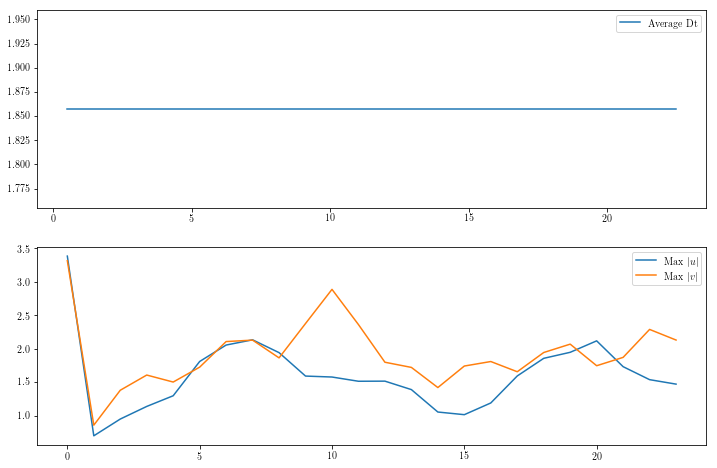

In [43]:
plt.figure(figsize=(12,8))
plotStatistics(casename+"lowres.nc")

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

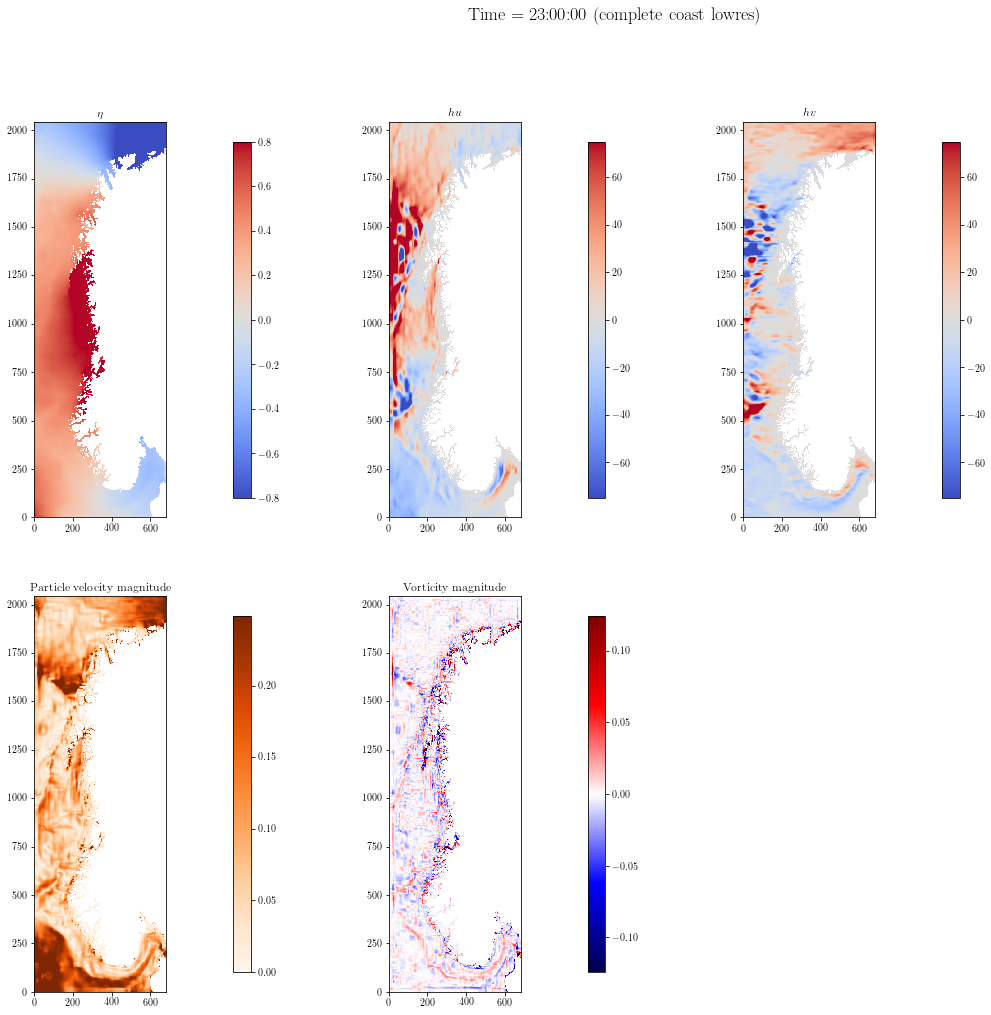

In [44]:
ncAnimation(casename+"lowres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True,
             downsample=1)

# Simulate high-resolution

In [45]:
#Set scaling factor
scale = 2

importlib.reload(Common)

nx_new = (x1 - x0)*scale - sponge_cells[1] - sponge_cells[3]
ny_new = (y1 - y0)*scale - sponge_cells[0] - sponge_cells[2]

data_args = {"nx": nx_new, "ny": ny_new,
             "dx": dx/scale, "dy": dy/scale,
             "H": OceanographicUtilities.rescaleIntersections(H_i, (H_i.shape[1]-1)*scale+1, (H_i.shape[0]-1)*scale+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind_stress": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename=casename+"highres.nc",
             timesteps=time,
             interior_domain_only=False)

File complete_coast_2019_10_17/complete_coast_highres.nc already exists, skipping simulation.


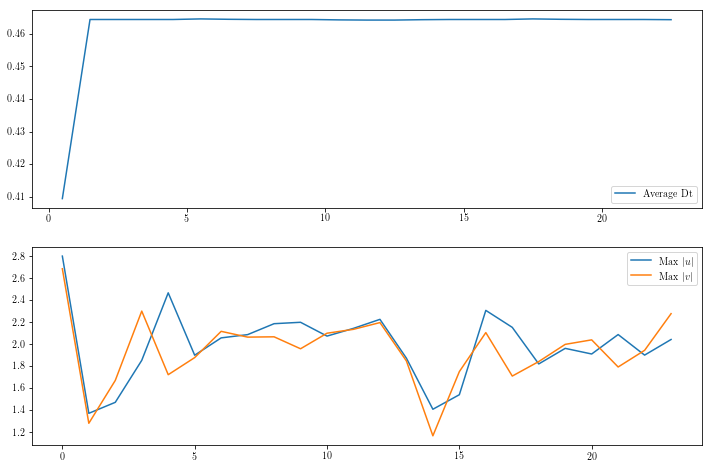

In [46]:
plt.figure(figsize=(12,8))
plotStatistics(casename+"highres.nc")

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

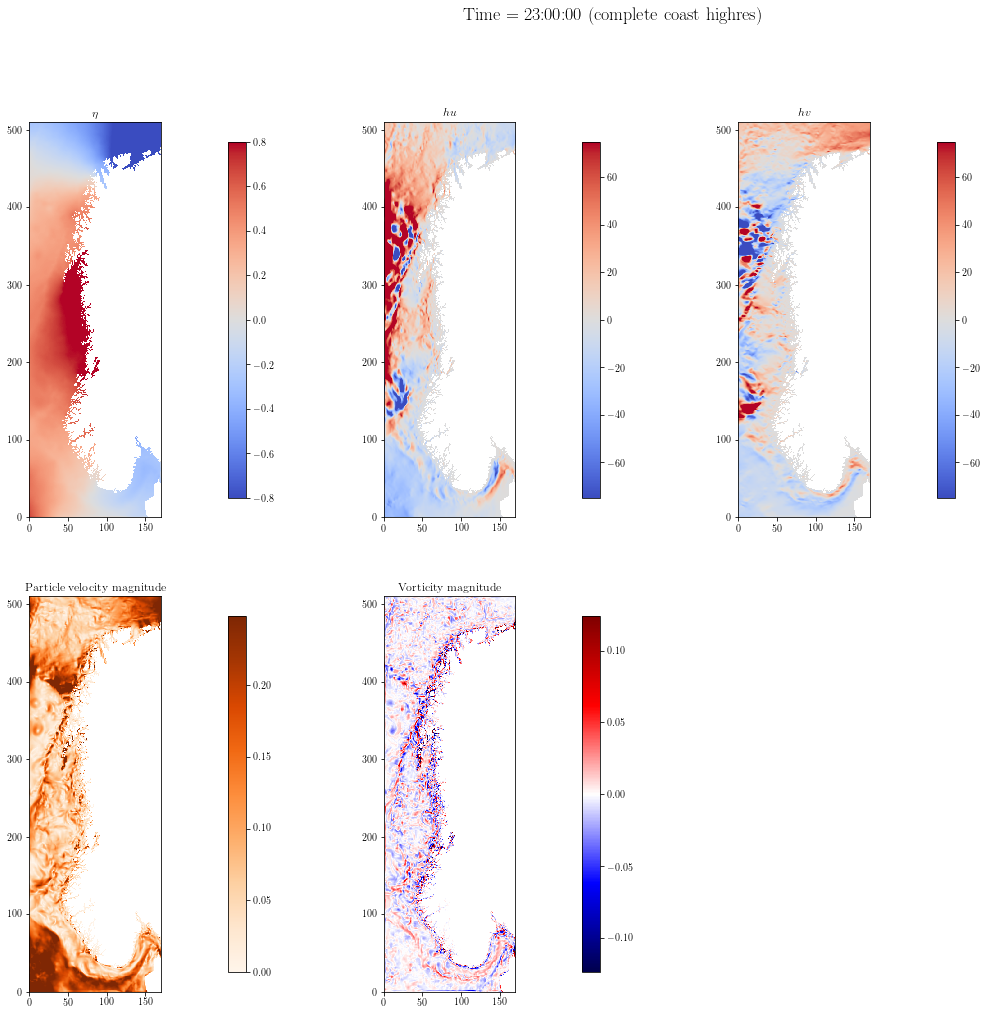

In [47]:
ncAnimation(casename+"highres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True,
             downsample=4)

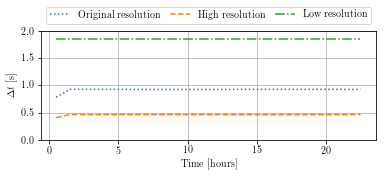